<a href="https://colab.research.google.com/github/Jalalbaim/Auto-Encoder/blob/main/Variational_Auto_Encoder_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational auto encoder - vae
***
BAIM Mohamed

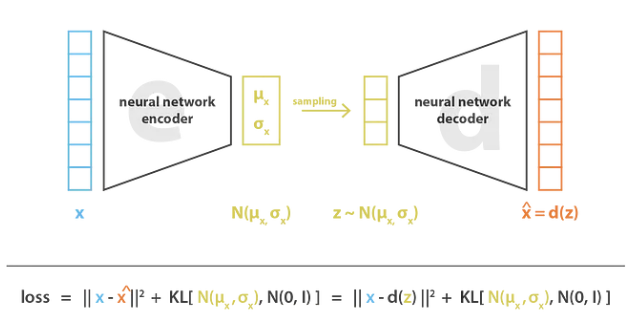

In [83]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn, optim
from tqdm import tqdm
from collections import defaultdict

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## **Fashion MNIST**


In [85]:
# Dataset

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [86]:
# Labels
label_index = training_data.targets[0]
label_name = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
][label_index]

print("Label index:", label_index)
print("Label name:", label_name)

Label index: tensor(9)
Label name: Ankle boot


In [87]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


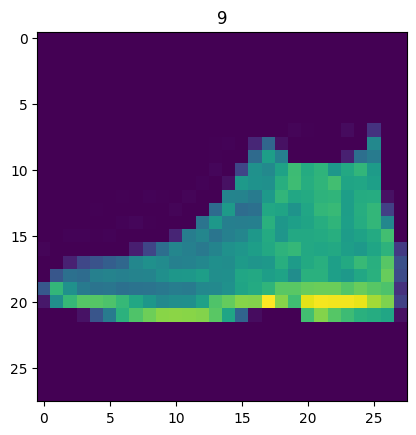

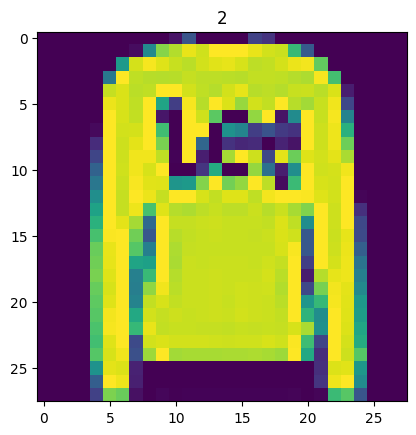

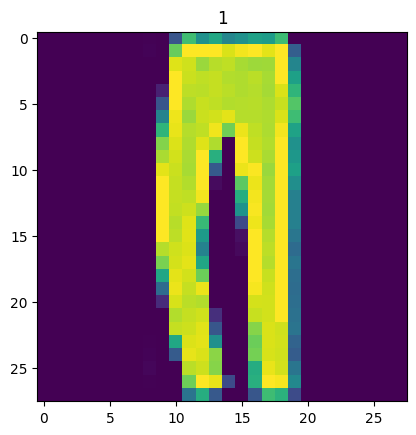

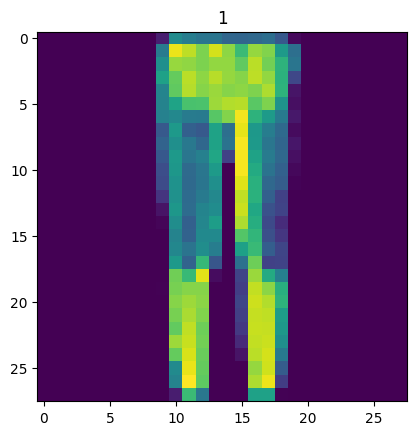

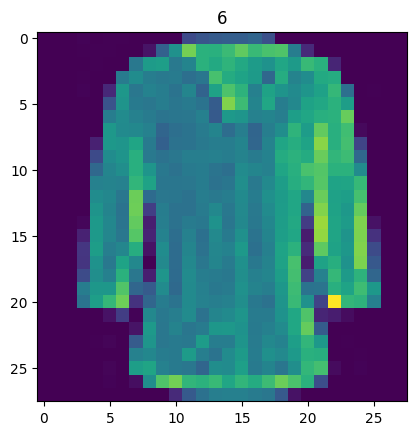

In [88]:
# visualization de Fashion MNIST
for i in range(5):
  image, label = test_data[i]
  plt.imshow(image.cpu().reshape(28,28))
  plt.title(label)
  plt.axis('on')
  plt.show()

## **MNIST**


In [89]:
# Dataset

training_data_MNIST = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)


test_data_MNIST = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [90]:
batch_size = 64

train_dataloader_MNIST = DataLoader(training_data_MNIST, batch_size=batch_size)
test_dataloader_MNIST = DataLoader(test_data_MNIST, batch_size=batch_size)

for X, y in test_dataloader_MNIST:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


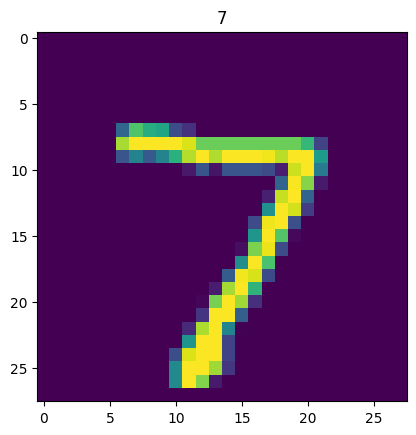

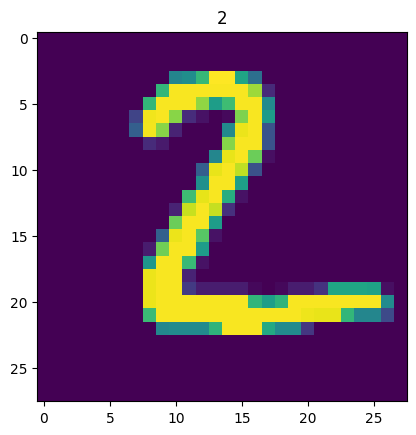

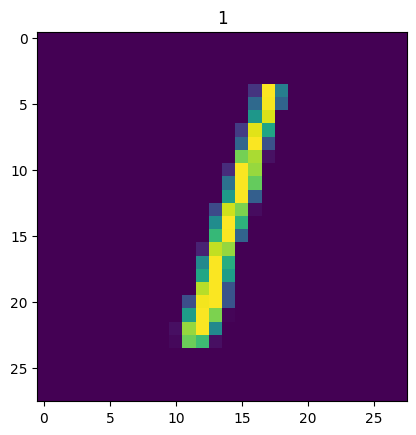

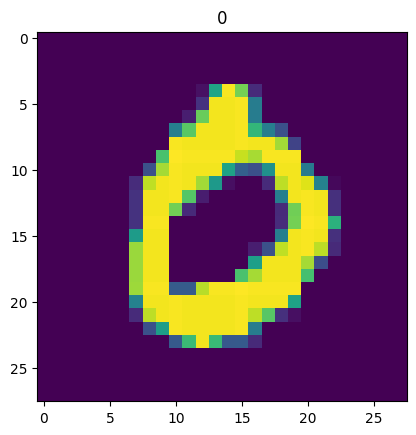

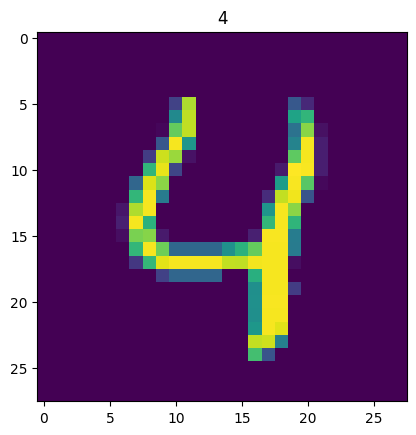

In [91]:
for i in range(5):
  image, label = test_data_MNIST[i]
  plt.imshow(image.cpu().reshape(28,28))
  plt.title(label)
  plt.axis('on')
  plt.show()

## **Variational auto encoder VAE**

In [92]:
class VAE_base(nn.Module):
    def __init__(self, encoder, decoder, latent_dim):
        super(VAE_base, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def forward(self, x):
        encoded = self.encoder(x)
        z_mean = encoded[:, :self.latent_dim]
        z_log_var = encoded[:, self.latent_dim:]
        z = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(z)
        return decoded, z_mean, z_log_var, z

    def reparameterize(self, z_mean, z_log_var):
        std =  torch.sqrt(torch.exp(z_log_var))
        eps = torch.randn_like(std)
        return z_mean + eps * std

class VAutoEncoder(VAE_base):
    def __init__(self, input_dim, latent_dim):
        encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 2 * latent_dim)
        )
        decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )
        super(VAutoEncoder, self).__init__(encoder=encoder, decoder=decoder, latent_dim=latent_dim)


In [93]:
def loss_fn(decoded, x, z_mean, z_log_var):
    """
    Compute the VAE loss function.

    :param decoded: The output of the decoder (reconstructed input).
    :param x: The original input data (target for reconstruction).
    :param z_mean: The mean of the latent distribution.
    :param z_log_var: The log variance of the latent distribution.
    :return: Tuple containing the total loss, reconstruction loss, and KL divergence.
    """
    batch_size = x.size(0)

    # assurer le log
    decoded = torch.clamp(decoded, 1e-8, 1 - 1e-8)

    # Reconstruction loss
    recon_loss = F.mse_loss(decoded, x, reduction='sum') / batch_size

    # KL divergence
    kl_divergence = 0.5 * torch.sum(
        torch.exp(z_log_var) + z_mean**2 - 1. - z_log_var
    ) / batch_size

    # Total loss
    total_loss = recon_loss + kl_divergence

    return total_loss, recon_loss, kl_divergence

In [94]:
def train_vae(model, dataloader, optimizer, loss_fn, device, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass: compute predicted output by passing data to the model
        decoded, z_mean, z_log_var, z = model(data)
        decoded_reshaped = decoded.view_as(data)

        # Compute loss
        total_loss, recon_loss, kl_divergence = loss_fn(decoded_reshaped, data, z_mean, z_log_var)

        # Backward pass: compute gradient of the loss with respect to model parameters
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()

        # Optionally print statistics
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} ({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {total_loss.item():.6f}')

    average_loss = train_loss / len(dataloader)
    print(f"Average Loss: {average_loss:.4f}")
    return average_loss

In [95]:
# visualize reconstruction

def visualize_reconstructions(model, dataloader, num_images=5):
    model.eval()
    figure, axes = plt.subplots(2, num_images, figsize=(10, 4))

    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            if i >= num_images:
                break
            data = data.to(next(model.parameters()).device)
            reconstruction, _, _, _ = model(data.view(data.size(0), -1))

            original = data.view(data.shape[0], 28, 28)
            recon = reconstruction.view(reconstruction.shape[0], 28, 28)

            ax = axes[0, i]
            ax.imshow(original[i].cpu().numpy())
            ax.axis('off')
            ax.set_title('Original')

            ax = axes[1, i]
            ax.imshow(recon[i].cpu().numpy())
            ax.axis('off')
            ax.set_title('Reconstructed')

    plt.show()

In [96]:
# visualize latent space
def visualize_latent_space_batched(model, dataloader, device):
    model.eval()
    model.to(device)
    zs = defaultdict(list)
    COLORS = ['red', 'blue', 'green', 'yellow', 'orange', 'cyan', 'gray', 'black', 'purple', 'pink']

    batch_count = 0
    for data, labels in tqdm(dataloader, desc='Processing'):
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        z_means = output[1]

        for label, z_mean in zip(labels, z_means):
            zs[label.item()].append(z_mean.detach().cpu())

        batch_count += 1

    zs = {k: torch.stack(v) for k, v in zs.items()}
    zs = dict(sorted(zs.items()))

    plt.figure(figsize=(12, 8))
    for i, (label, z) in enumerate(zs.items()):
        z = z.numpy()
        plt.scatter(z[:, 0], z[:, 1], color=COLORS[i % len(COLORS)], label=f'Label {label}')

    plt.legend()
    plt.title('Latent Space')
    plt.xlabel('dimension 1')
    plt.ylabel('dimension 2')
    plt.show()

In [102]:
#def visualize_latent_var(model, dataloader, device, num_batches=5):


## Application du VAE sur Fashion MNIST

In [98]:
vae_FMNIST = VAutoEncoder(28*28, 2).to(device)
dataloader = train_dataloader
optimizer = optim.Adam(vae_FMNIST.parameters(), lr=1e-3)

"""
loss_fn = nn.BCELoss(reduction = 'sum')
"""
epochs = 10

for epoch in range(epochs):
  print("--------------------------")
  print(f"Epoch {epoch}")
  train_vae(vae_FMNIST, dataloader, optimizer, loss_fn, device ,epoch)


--------------------------
Epoch 0
Epoch: 0 [0/60000 (0%)]	Loss: 138.599792
Epoch: 0 [6400/60000 (11%)]	Loss: 36.939159
Epoch: 0 [12800/60000 (21%)]	Loss: 34.757484
Epoch: 0 [19200/60000 (32%)]	Loss: 31.787865
Epoch: 0 [25600/60000 (43%)]	Loss: 34.667110
Epoch: 0 [32000/60000 (53%)]	Loss: 32.776165
Epoch: 0 [38400/60000 (64%)]	Loss: 29.677250
Epoch: 0 [44800/60000 (75%)]	Loss: 30.982044
Epoch: 0 [51200/60000 (85%)]	Loss: 32.022568
Epoch: 0 [57600/60000 (96%)]	Loss: 29.769718
Average Loss: 36.4741
--------------------------
Epoch 1
Epoch: 1 [0/60000 (0%)]	Loss: 32.560669
Epoch: 1 [6400/60000 (11%)]	Loss: 29.329721
Epoch: 1 [12800/60000 (21%)]	Loss: 31.029030
Epoch: 1 [19200/60000 (32%)]	Loss: 30.014301
Epoch: 1 [25600/60000 (43%)]	Loss: 32.000568
Epoch: 1 [32000/60000 (53%)]	Loss: 31.944891
Epoch: 1 [38400/60000 (64%)]	Loss: 28.466263
Epoch: 1 [44800/60000 (75%)]	Loss: 30.342768
Epoch: 1 [51200/60000 (85%)]	Loss: 31.466757
Epoch: 1 [57600/60000 (96%)]	Loss: 28.481224
Average Loss: 31.80

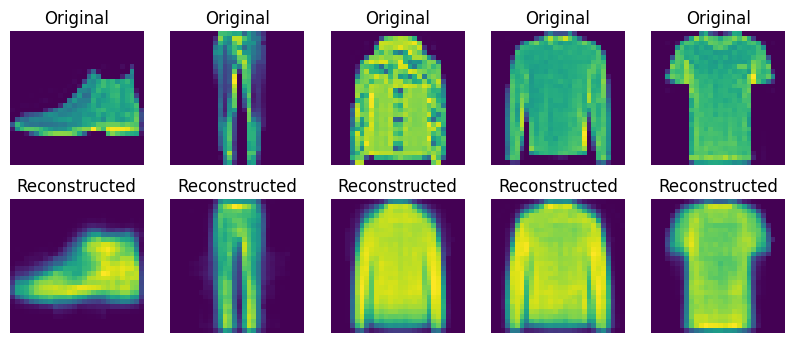

In [99]:
# visualisation sur Fashion MNIST
visualize_reconstructions(vae_FMNIST, test_dataloader)

Processing: 100%|██████████| 157/157 [00:01<00:00, 100.06it/s]


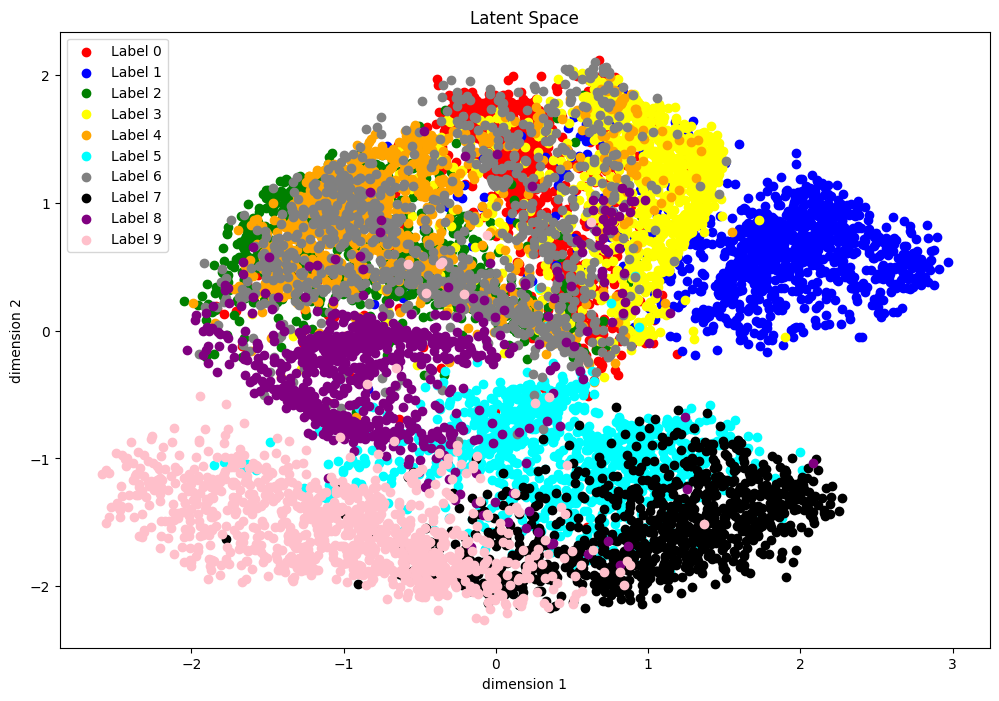

In [100]:
visualize_latent_space_batched(vae_FMNIST, test_dataloader, device)

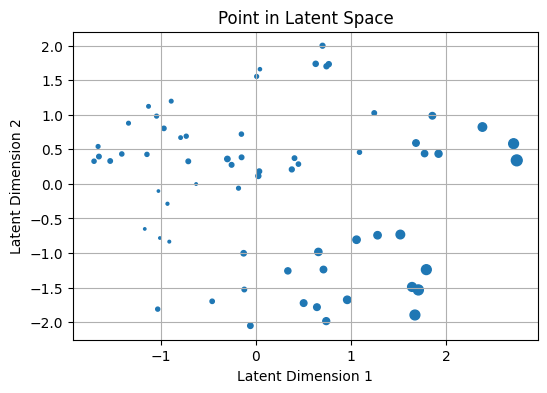

In [133]:
vae_FMNIST.eval()

data, _ = next(iter(test_dataloader))
data = data.to(device)

with torch.no_grad():
    _, z_mean, z_log_var, _ = vae_FMNIST(data)

    z_var = torch.exp(z_log_var)

    # Calculate point sizes (proportional to the variance)
    point_sizes = z_var.cpu().numpy() * 1000  # Adjust scaling factor to taste

    # Ensure point_sizes is scalar or matches the number of points
    #point_sizes = np.maximum(point_sizes,)  # Ensure minimal visible size

    # Plot the first two dimensions of z_mean in the latent space
    plt.figure(figsize=(6, 4))
    plt.scatter(z_mean.cpu().numpy()[:, 0], z_mean.cpu().numpy()[:, 1], s=point_sizes[:,0])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Point in Latent Space')
    plt.grid(True)
    plt.show()

## Application du VAE sur MNIST

In [ ]:
vae_MNIST = VAutoEncoder(28*28, 2).to(device)
dataloader = train_dataloader_MNIST
optimizer = optim.Adam(vae_MNIST.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
  print("--------------------------")
  print(f"Epoch {epoch}")
  train_vae(vae_MNIST, dataloader, optimizer, loss_fn, device ,epoch)

In [ ]:
visualize_reconstructions(vae_MNIST, test_dataloader_MNIST)

In [ ]:
visualize_latent_space_batched(vae_MNIST, test_dataloader_MNIST, device)

In [ ]:
visualize_latent_var(vae_MNIST, test_dataloader_MNIST, device)

## Analyse sur le nombre de tirages

## Visualisation de l'espace latent en fonction de la variance

## test sur MNIST, fashion MNIST, analyse sur la valeur de nombre de tirage, la dimension de l espace latent ...
## visualisation des point dont la taille proportionnelle à la variance  